# Domain names

In [1]:
DGA_MODEL_NAME = "prajjwal1/bert-medium"
MALWARE_MODEL_NAME = "google/electra-base-discriminator"
PHISHING_MODEL_NAME = "distilbert-base-uncased"

## DGA

/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/1503037935.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


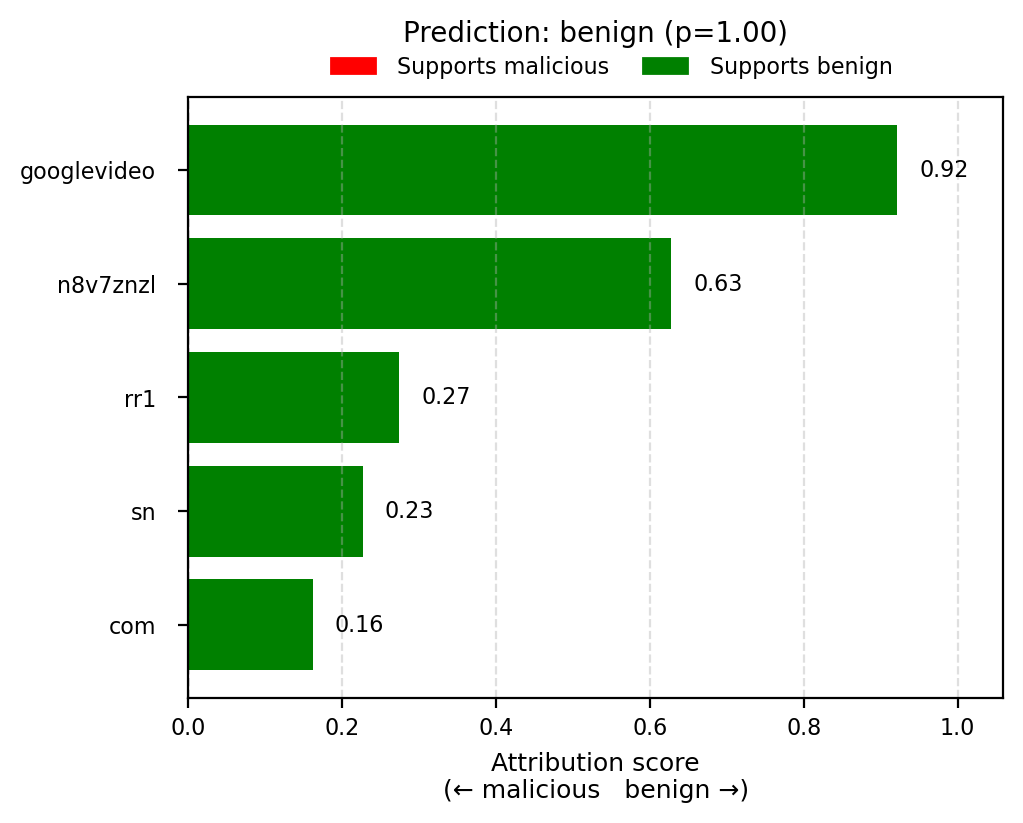

In [2]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt"
tokenizer = AutoTokenizer.from_pretrained(DGA_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    DGA_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("rr1---sn-n8v7znzl.googlevideo.com")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


## Malware

In [ ]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt"
tokenizer = AutoTokenizer.from_pretrained(DGA_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    DGA_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("rr1---sn-n8v7znzl.googlevideo.com")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


In [ ]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt"
tokenizer = AutoTokenizer.from_pretrained(DGA_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    DGA_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("rr1---sn-n8v7znzl.googlevideo.com")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/952078545.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


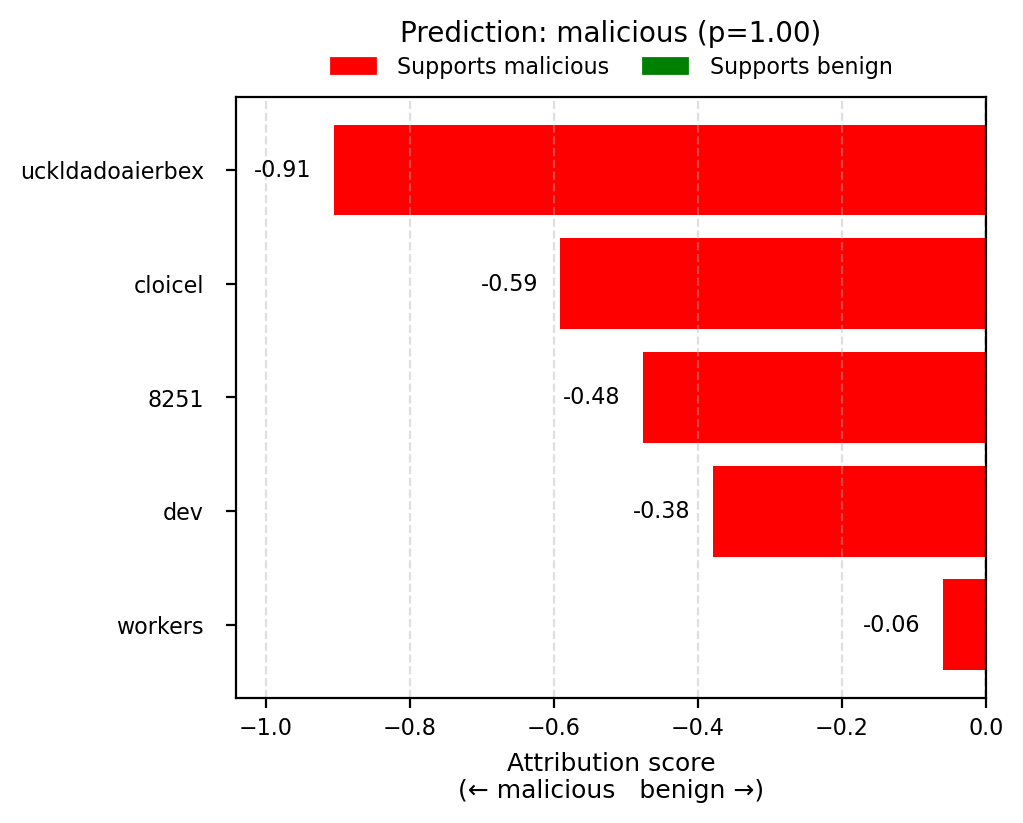

In [4]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_phish_distilbert-base-uncased_20250504_014049.pt"
tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("cloicel-8251.uckldadoaierbex.workers.dev")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/1854737563.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


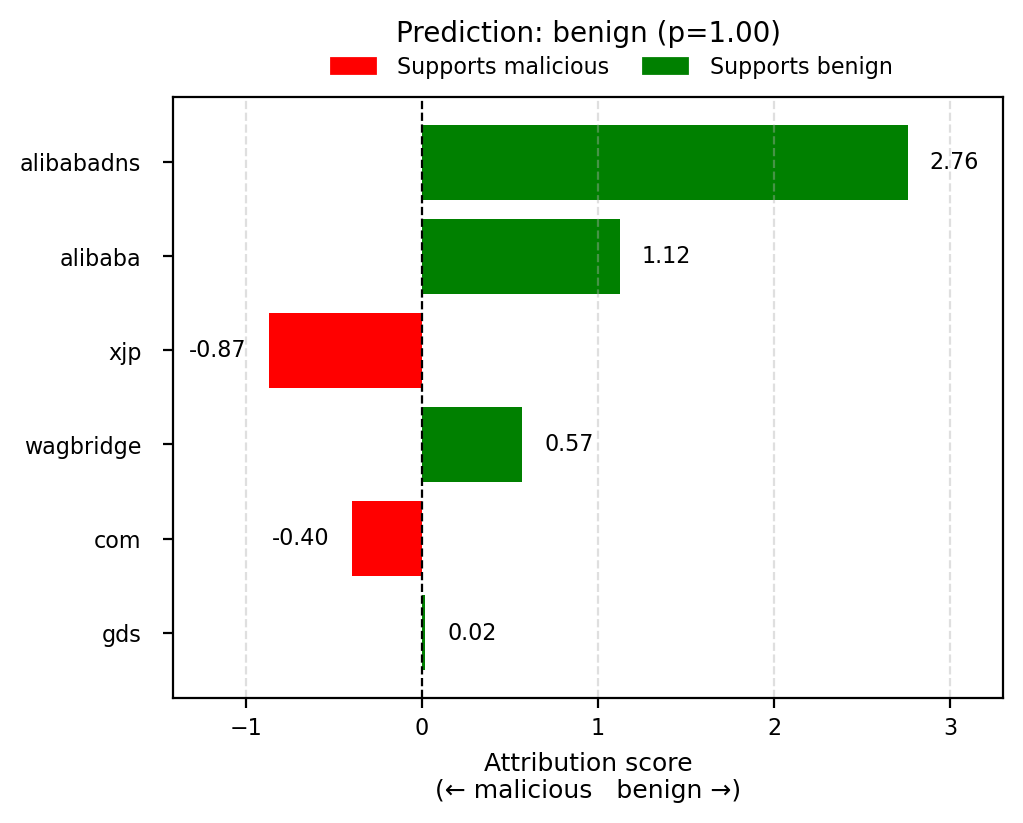

In [6]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/saved_models/BEST_phish_distilbert-base-uncased_20250504_014049.pt"
tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("xjp.wagbridge.alibaba.com.gds.alibabadns.com")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


# RDAP

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/2978158221.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


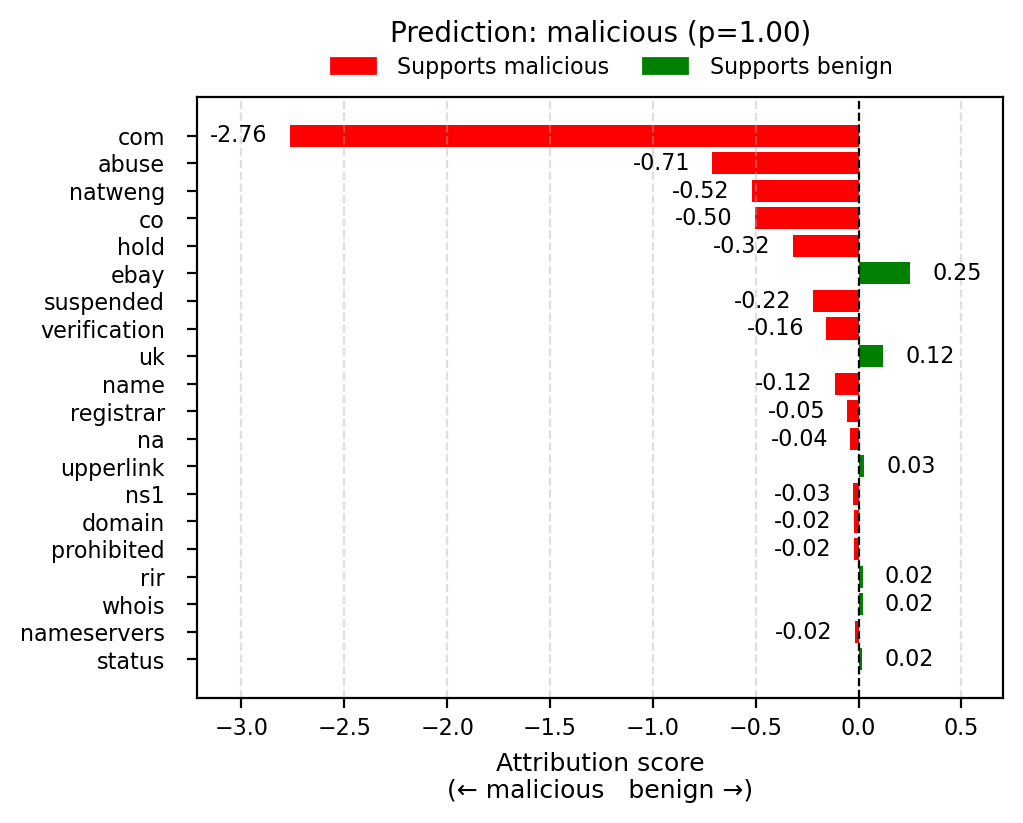

In [10]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/rdap/malware_electra-base-discriminator_20250512_174759_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    MALWARE_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: ebay.co.uk.natweng.com [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Upperlink Limited | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM, NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM [SEP] status: client transfer prohibited [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/1997752582.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


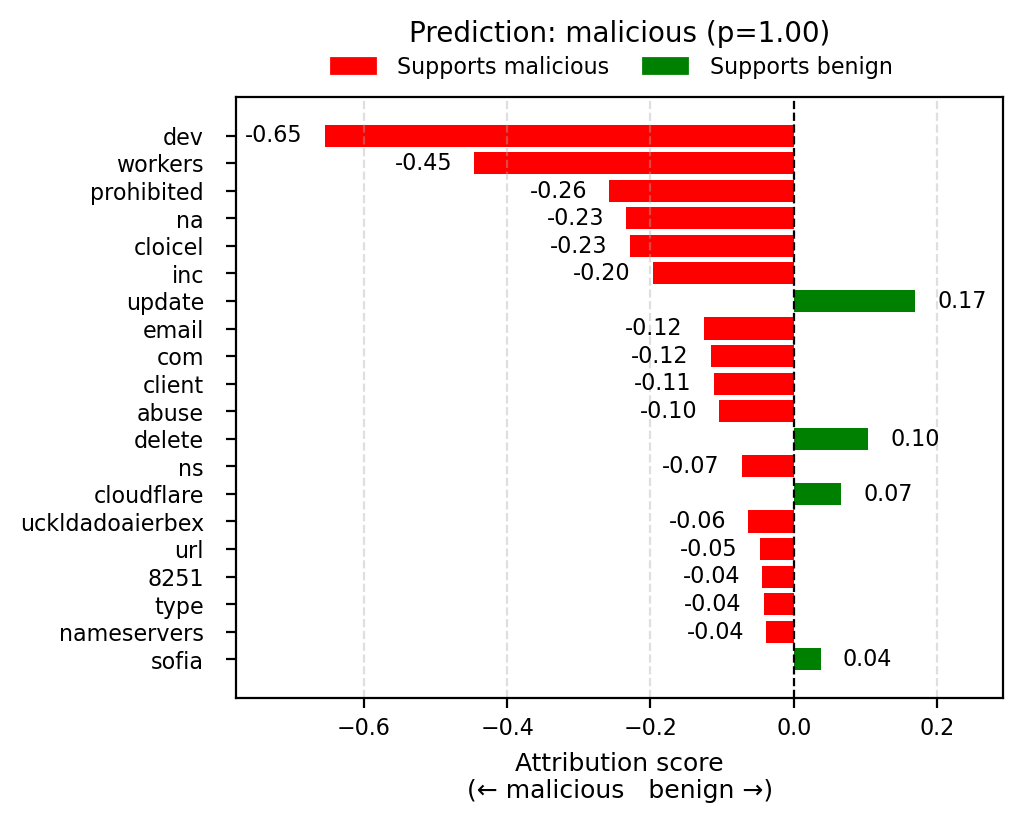

In [7]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/rdap/phishing_distilbert-base-uncased_20250512_201957_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: CloudFlare, Inc. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: DATA REDACTED | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: name: NA | email: NA | handle: NA | type: NA [SEP] nameservers: CLYDE.NS.CLOUDFLARE.COM, SOFIA.NS.CLOUDFLARE.COM [SEP] status: client delete prohibited, client transfer prohibited, client update prohibited [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


# DNS

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/3138082634.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


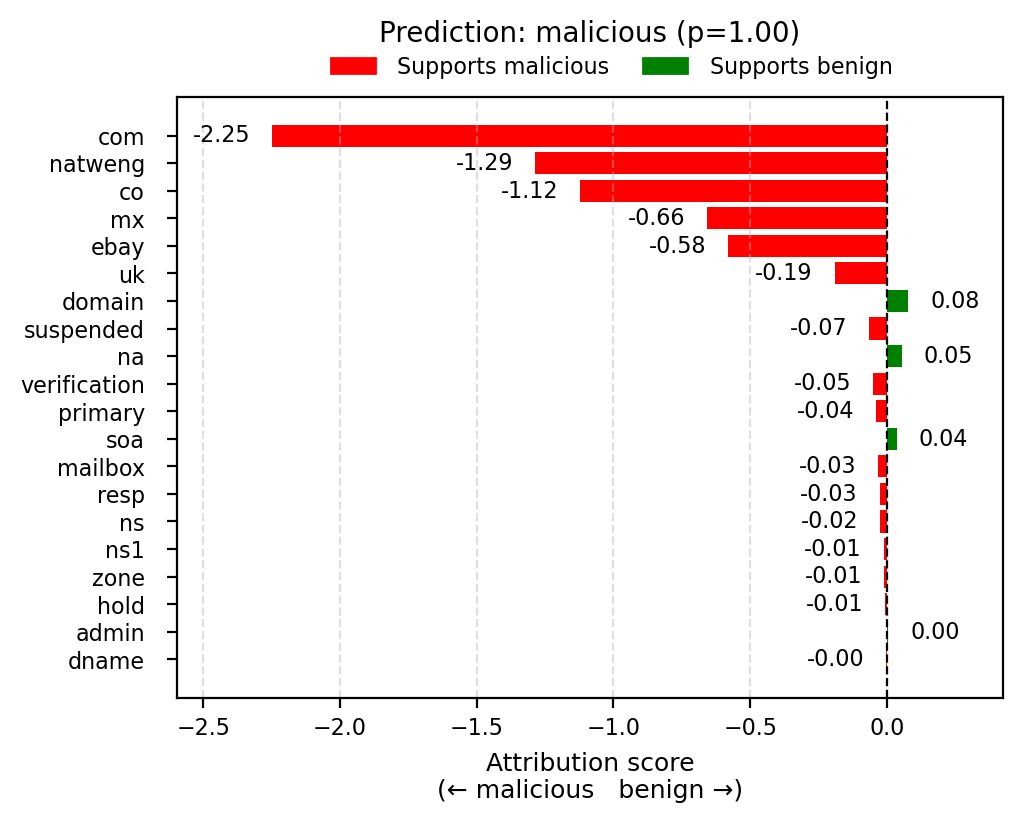

In [11]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/malware_electra-base-discriminator_20250512_220139_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    MALWARE_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: ebay.co.uk.natweng.com [SEP] MX: NA [SEP] NS: NA [SEP] SOA: primary_ns: ns1.verification-hold.suspended-domain.com | resp_mailbox_dname: admin.suspended-domain.com [SEP] zone_SOA: NA [SEP] remarks: zone: ebay.co.uk.natweng.com [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/813801056.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


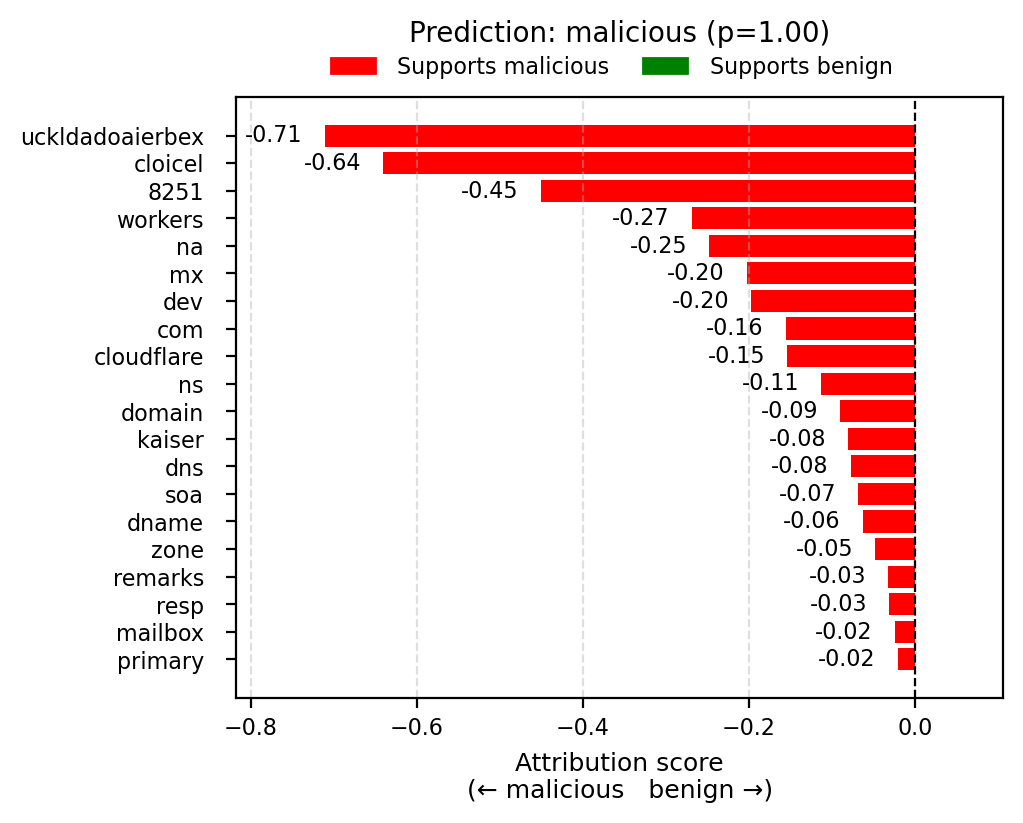

In [8]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] MX: NA [SEP] NS: NA [SEP] SOA: NA [SEP] zone_SOA: primary_ns: kaiser.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] remarks: zone: uckldadoaierbex.workers.dev [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


# GEO

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/1886660001.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


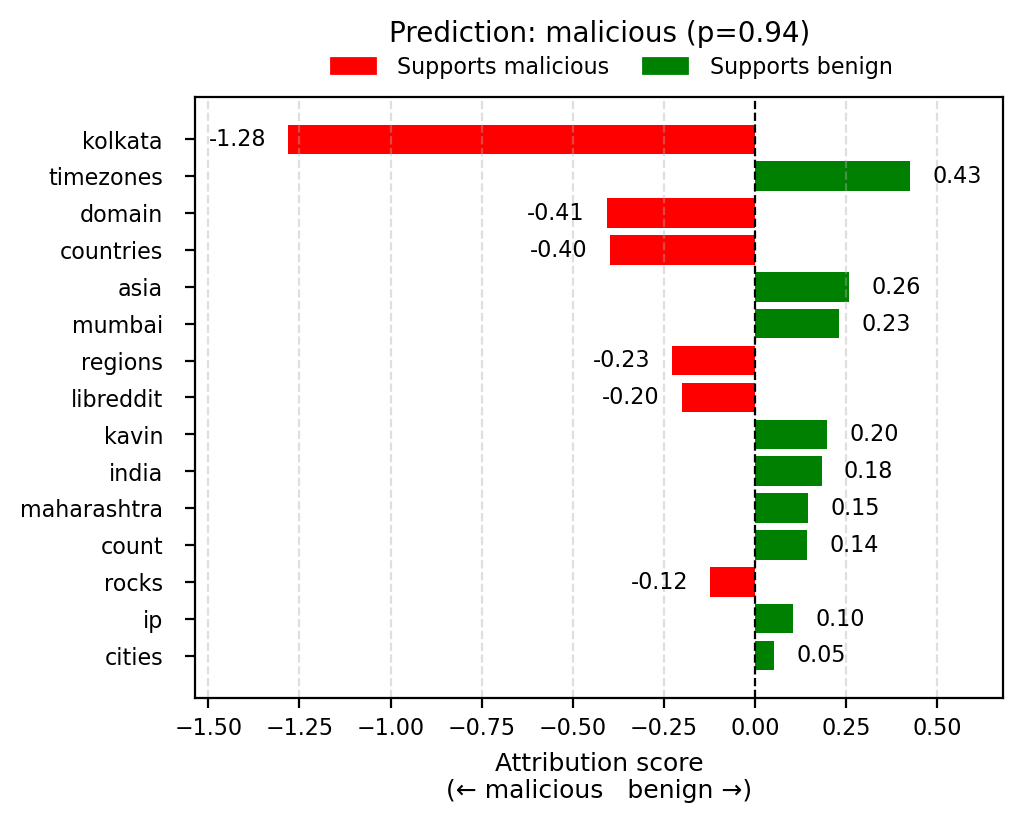

In [13]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/geo/malware_electra-base-discriminator_20250513_010704_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    MALWARE_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: libreddit.kavin.rocks [SEP] ip_count: 2 [SEP] countries: India [SEP] regions: Maharashtra [SEP] cities: Mumbai [SEP] timezones: Asia/Kolkata [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
# ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)
ax.set_title(f"Prediction: malicious (p=0.94)", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_184022/2075822048.py:123: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.50)  # room for negative labels


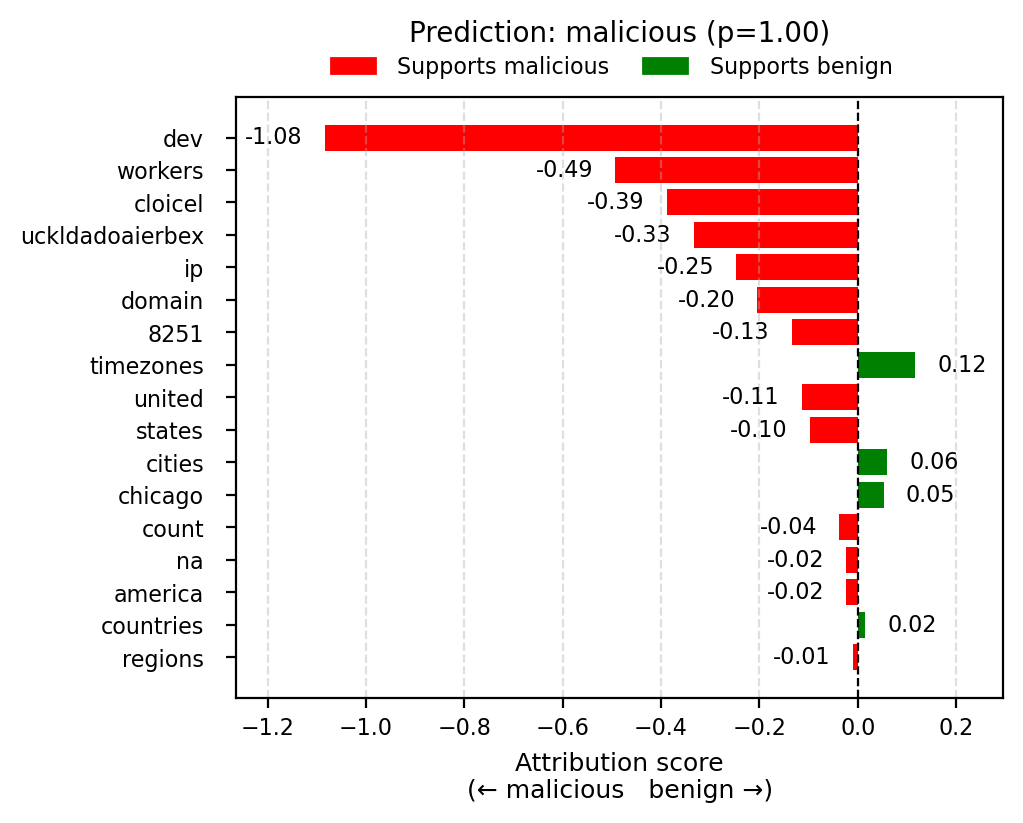

In [9]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import  AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# ─── 0) global font settings ──────────────────────────────────────────────────
plt.rcParams.update({
    "font.size":         8,    # base font size for tick labels, etc.
    "axes.titlesize":    10,   # title
    "axes.labelsize":    9,    # x/y axis labels
    "xtick.labelsize":   8,    # x-tick labels
    "ytick.labelsize":   8,    # y-tick labels
    "legend.fontsize":   8,    # legend text
})

# ─── 1) load model + tokenizer ───────────────────────────────────────────────
MODEL_CHECKPOINT = "../models/geo/phishing_distilbert-base-uncased_20250513_013233_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

# ─── 2) your DNS record ───────────────────────────────────────────────────────
record = (
    "[CLS] domain: tvetreform.org.pk [SEP] "
    "MX: mx2.titan.email, mx1.titan.email [SEP] "
    "NS: brenda.ns.cloudflare.com, kolton.ns.cloudflare.com [SEP] "
    "SOA: primary_ns: brenda.ns.cloudflare.com | "
    "resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "zone_SOA: NA [SEP] remarks: zone: tvetreform.org.pk [SEP]"
)
record = ("[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] ip_count: 4 [SEP] countries: United States [SEP] regions: NA [SEP] cities: NA [SEP] timezones: America/Chicago [SEP]")
enc = tokenizer(record, return_tensors="pt")
input_ids      = enc["input_ids"]
attention_mask = enc["attention_mask"]

# ─── 3) model prediction ──────────────────────────────────────────────────────
with torch.no_grad():
    logits    = model(input_ids, attention_mask=attention_mask).logits
    probs     = torch.softmax(logits, dim=1)[0]
    pred_idx  = probs.argmax().item()              # 0=benign, 1=malicious
    pred_lbl  = ["benign","malicious"][pred_idx]
    pred_conf = probs[pred_idx].item()

# ─── 4) Integrated Gradients targeting benign logit ──────────────────────────
embedding_layer = model.get_input_embeddings()
embeds   = embedding_layer(input_ids)
embeds.requires_grad_(True)
baseline = torch.zeros_like(embeds)

def forward_benign(x, mask):
    return model(
        input_ids=None,
        inputs_embeds=x,
        attention_mask=mask
    ).logits[:, 0]   # target class 0 = benign

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeds,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50,
)

# collapse → detach → numpy
token_attrs = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)

raw_toks   = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
raw_scores = token_attrs

# ─── 5) merge subwords + drop punctuation ─────────────────────────────────────
words, word_scores = [], []
for tok, sc in zip(raw_toks, raw_scores):
    if tok in tokenizer.all_special_tokens:        continue
    if re.fullmatch(r"[^\w]+", tok):               continue
    if tok.startswith("##"):
        words[-1]       += tok[2:]
        word_scores[-1] += sc
    else:
        words.append(tok)
        word_scores.append(sc)

# ─── 6) aggregate duplicates & drop 1-char tokens ────────────────────────────
agg = OrderedDict()
for w,s in zip(words, word_scores):
    agg[w] = agg.get(w, 0.0) + s
words, word_scores = list(agg.keys()), list(agg.values())

# drop single-char remnants
filtered = [(w,s) for w,s in zip(words, word_scores) if len(w)>1]
if filtered:
    words, word_scores = zip(*filtered)
else:
    words, word_scores = list(words), list(word_scores)

# ─── 7) top-K by absolute score ───────────────────────────────────────────────
K = 20
order     = np.argsort(np.abs(word_scores))[::-1][:K]
top_words = [words[i]       for i in order]
top_scores= [word_scores[i]  for i in order]

# ─── 8) PLOT ──────────────────────────────────────────────────────────────────
# choose a smaller figure, but high DPI so text stays crisp
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words)*0.20)),
    dpi=200,
    constrained_layout=True,
)
plt.subplots_adjust(left=0.50)  # room for negative labels

bars = ax.barh(
    top_words,
    top_scores,
    color=["green" if s>0 else "red" for s in top_scores]
)

ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.tick_params(axis="y", pad=8)

ax.xaxis.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Attribution score\n(← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)


# legend just under the title
red_patch   = mpatches.Patch(color="red",   label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False,
    handletextpad=1,
    columnspacing=1.5
)

plt.show()
